In [1]:
%load_ext autoreload
%autoreload 2

from importlib.util import find_spec
if find_spec("core") is None:
    import sys
    sys.path.append('..')
    
import pandas as pd
import numpy as np

import os
import sys
import glob
from tqdm.notebook import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

import librosa
import librosa.display
from IPython.display import Audio

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import StratifiedKFold, train_test_split


#import cv2
#from PIL import Image

#from typing import Dict, Any
#import math

import torch
from torch import LongTensor, FloatTensor, HalfTensor, Tensor
from torch.utils.data import Dataset, DataLoader
from copy import deepcopy
from torch import nn, optim
import torch.nn.functional as F
import inspect

from catalyst import dl, utils
import timm

from resemblyzer import preprocess_wav, VoiceEncoder
from spectralcluster import SpectralClusterer
from resemblyzer.audio import sampling_rate as resempler_sampling_rate
resemblyzer_encoder = VoiceEncoder()#"cuda:0"

#from torch.fft import fft, ifft
#from torchaudio.functional import bandpass_biquad
#from nnAudio.Spectrogram import CQT1992v2
#import torchvision.models as models

%matplotlib inline

Loaded the voice encoder model on cpu in 0.03 seconds.


In [2]:
from providers.stream_telecom import create_dataframe_from_markup_stream
from core.datasets import BasicAudioDataset

In [3]:
PATH_STREAM_MARKUP = '../datasets/stream_telecom_markup'
phrase_df = create_dataframe_from_markup_stream(PATH_STREAM_MARKUP).reset_index(drop=True)

phrase_df.drop(columns=['phrase_text', 'language', 'emotion'], inplace=True)

phrase_df['speaker_id'] = phrase_df.apply(lambda row: row['speaker']+'_'+row['audio_filepath'].split('/')[-2].replace(' ',''), axis=1)

phrase_df.head()

,phrase_start,phrase_stop,speaker,audio_filepath,speaker_id
0,0.000000,10.948668,customer,../datasets/stream_telecom_markup/neutral 4674...,customer_neutral4674
1,13.511122,15.530026,sales,../datasets/stream_telecom_markup/neutral 4674...,sales_neutral4674
2,16.461827,17.315979,customer,../datasets/stream_telecom_markup/neutral 4674...,customer_neutral4674
3,17.315979,22.285587,sales,../datasets/stream_telecom_markup/neutral 4674...,sales_neutral4674
4,22.285587,24.188015,customer,../datasets/stream_telecom_markup/neutral 4674...,customer_neutral4674


In [4]:
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
speaker_label_encoder = LabelEncoder()
speaker_minmax_scaler = MinMaxScaler()

phrase_df['encoded_speaker_id'] = speaker_label_encoder.fit_transform(phrase_df['speaker_id'])
phrase_df['target'] = speaker_minmax_scaler.fit_transform(phrase_df['encoded_speaker_id'].values.reshape(-1,1))
phrase_df

,phrase_start,phrase_stop,speaker,audio_filepath,speaker_id,encoded_speaker_id,target
0,0.000000,10.948668,customer,../datasets/stream_telecom_markup/neutral 4674...,customer_neutral4674,43,0.272152
1,13.511122,15.530026,sales,../datasets/stream_telecom_markup/neutral 4674...,sales_neutral4674,123,0.778481
2,16.461827,17.315979,customer,../datasets/stream_telecom_markup/neutral 4674...,customer_neutral4674,43,0.272152
3,17.315979,22.285587,sales,../datasets/stream_telecom_markup/neutral 4674...,sales_neutral4674,123,0.778481
4,22.285587,24.188015,customer,../datasets/stream_telecom_markup/neutral 4674...,customer_neutral4674,43,0.272152
...,...,...,...,...,...,...,...
507,0.000000,12.987151,customer,../datasets/stream_telecom_markup/sad98/163092...,customer_sad98,78,0.493671
508,15.348451,18.440630,sales,../datasets/stream_telecom_markup/sad98/163092...,sales_sad98,157,0.993671
509,26.873845,29.853581,sales,../datasets/stream_telecom_markup/sad98/163092...,sales_sad98,157,0.993671
510,29.853581,31.877553,customer,../datasets/stream_telecom_markup/sad98/163092...,customer_sad98,78,0.493671


In [5]:
audio_dict = phrase_df[['audio_filepath']].drop_duplicates().reset_index(drop=True).to_dict('index')

inverted_audio_dict = {}
for key, value in audio_dict.items():
    inverted_audio_dict[value['audio_filepath']] = key
    
for audio_id in tqdm(audio_dict):
    
    input_audio_wave, audio_sampling_rate= librosa.load(audio_dict[audio_id]['audio_filepath'], sr=None)
    #audio_wave_resempler_sr = librosa.resample(input_audio_wave, audio_sampling_rate, resempler_sampling_rate)
    #audio_without_silence = preprocess_wav(audio_wave_resempler_sr)
    
    
    audio_dict[audio_id]['audio_wave']= input_audio_wave
    audio_dict[audio_id]['sampling_rate'] = audio_sampling_rate
    
audio_df = pd.DataFrame(audio_dict).T
audio_df.head()

  0%|          | 0/81 [00:00<?, ?it/s]

,audio_filepath,audio_wave,sampling_rate
0,../datasets/stream_telecom_markup/neutral 4674...,"[0.0002746582, 0.00018310547, 6.1035156e-05, 3...",8000
1,../datasets/stream_telecom_markup/angry7865/16...,"[0.0005187988, 0.00030517578, -9.1552734e-05, ...",8000
2,../datasets/stream_telecom_markup/neutral6/163...,"[-0.017578125, -0.022155762, -0.033447266, -0....",8000
3,../datasets/stream_telecom_markup/neutral8/163...,"[0.00021362305, 0.00021362305, 0.00018310547, ...",8000
4,../datasets/stream_telecom_markup/neutral34567...,"[0.025787354, 0.021575928, 0.019012451, 0.0159...",8000


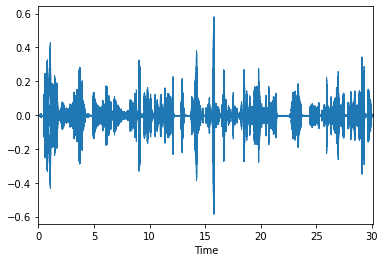

In [6]:
sample_audio = audio_df.iloc[0]

librosa.display.waveplot(sample_audio.audio_wave, sr=sample_audio.sampling_rate)
Audio(sample_audio.audio_wave, rate=sample_audio.sampling_rate)

In [7]:
phrase_df['audio_id'] = phrase_df['audio_filepath'].replace(inverted_audio_dict)
phrase_df.sample(3)

,phrase_start,phrase_stop,speaker,audio_filepath,speaker_id,encoded_speaker_id,target,audio_id
173,9.695210,17.938615,customer,../datasets/stream_telecom_markup/angry32/1630...,customer_angry32,4,0.025316,28
449,69.353359,74.301894,customer,../datasets/stream_telecom_markup/sad348765/16...,customer_sad348765,73,0.462025,69
139,3.570618,14.068234,sales,../datasets/stream_telecom_markup/neutral23451...,sales_neutral23451,113,0.715190,22


In [8]:
target_sampling_rate = 8000
phrase_df['phrase_audio'] = phrase_df.apply(lambda row: audio_df['audio_wave'].iloc[row['audio_id']][int(target_sampling_rate*row['phrase_start']):
                                                         int(target_sampling_rate*row['phrase_stop'])], axis=1)
phrase_df.head()

,phrase_start,phrase_stop,speaker,audio_filepath,speaker_id,encoded_speaker_id,target,audio_id,phrase_audio
0,0.000000,10.948668,customer,../datasets/stream_telecom_markup/neutral 4674...,customer_neutral4674,43,0.272152,0,"[0.0002746582, 0.00018310547, 6.1035156e-05, 3..."
1,13.511122,15.530026,sales,../datasets/stream_telecom_markup/neutral 4674...,sales_neutral4674,123,0.778481,0,"[0.00021362305, 0.00061035156, 9.1552734e-05, ..."
2,16.461827,17.315979,customer,../datasets/stream_telecom_markup/neutral 4674...,customer_neutral4674,43,0.272152,0,"[0.0020446777, 0.013061523, 0.006866455, 0.002..."
3,17.315979,22.285587,sales,../datasets/stream_telecom_markup/neutral 4674...,sales_neutral4674,123,0.778481,0,"[0.0005187988, 0.0004272461, 0.00024414062, 0...."
4,22.285587,24.188015,customer,../datasets/stream_telecom_markup/neutral 4674...,customer_neutral4674,43,0.272152,0,"[0.00045776367, 0.00024414062, 0.00018310547, ..."


In [9]:
## Mel-filterbank
mel_window_length = 25  # In milliseconds
mel_window_step = 10    # In milliseconds
mel_n_channels = 5#40


def wav_to_mel_spectrogram(wav):
    """
    Derives a mel spectrogram ready to be used by the encoder from a preprocessed audio waveform.
    Note: this not a log-mel spectrogram.
    """
    frames = librosa.feature.melspectrogram(
        wav,
        target_sampling_rate,
        n_fft=int(target_sampling_rate * mel_window_length / 1000),
        hop_length=int(target_sampling_rate * mel_window_step / 1000),
        n_mels=mel_n_channels
    )
    return frames.astype(np.float32).T

def apply_wav_to_mel_spectrogram(row):
    try:
        return wav_to_mel_spectrogram(row)
    except:
        print('a')
        return np.array([0])
    
phrase_df['mel_spectogram'] = phrase_df['phrase_audio'].apply(lambda row: apply_wav_to_mel_spectrogram(row))

phrase_df = phrase_df[phrase_df.mel_spectogram.apply(lambda row:row.shape) != (1,)].reset_index(drop=True)

phrase_df.head()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=200 is too small for input signal of length=0
  warnings.warn(


a


,phrase_start,phrase_stop,speaker,audio_filepath,speaker_id,encoded_speaker_id,target,audio_id,phrase_audio,mel_spectogram
0,0.000000,10.948668,customer,../datasets/stream_telecom_markup/neutral 4674...,customer_neutral4674,43,0.272152,0,"[0.0002746582, 0.00018310547, 6.1035156e-05, 3...","[[1.0858255e-06, 6.2613776e-07, 1.052664e-07, ..."
1,13.511122,15.530026,sales,../datasets/stream_telecom_markup/neutral 4674...,sales_neutral4674,123,0.778481,0,"[0.00021362305, 0.00061035156, 9.1552734e-05, ...","[[7.4186653e-07, 3.4876294e-08, 6.660335e-08, ..."
2,16.461827,17.315979,customer,../datasets/stream_telecom_markup/neutral 4674...,customer_neutral4674,43,0.272152,0,"[0.0020446777, 0.013061523, 0.006866455, 0.002...","[[0.0005981634, 9.1198366e-05, 7.957482e-06, 5..."
3,17.315979,22.285587,sales,../datasets/stream_telecom_markup/neutral 4674...,sales_neutral4674,123,0.778481,0,"[0.0005187988, 0.0004272461, 0.00024414062, 0....","[[2.5841345e-07, 2.1016267e-06, 8.269036e-07, ..."
4,22.285587,24.188015,customer,../datasets/stream_telecom_markup/neutral 4674...,customer_neutral4674,43,0.272152,0,"[0.00045776367, 0.00024414062, 0.00018310547, ...","[[1.6526144e-07, 1.6300817e-07, 7.966558e-09, ..."


In [10]:
rate=1.3
min_coverage=0.75
partials_n_frames = 160 

def compute_partial_slices(n_samples: int, rate, min_coverage):

    assert 0 < min_coverage <= 1

    
    # Compute how many frames separate two partial utterances
    samples_per_frame = int((resempler_sampling_rate * mel_window_step / 1000))
    n_frames = int(np.ceil((n_samples + 1) / samples_per_frame))
    frame_step = int(np.round((resempler_sampling_rate / rate) / samples_per_frame))
    assert 0 < frame_step, "The rate is too high"
    assert frame_step <= partials_n_frames, "The rate is too low, it should be %f at least" % \
        (resempler_sampling_rate / (samples_per_frame * partials_n_frames))

    # Compute the slices
    wav_slices, mel_slices = [], []
    steps = max(1, n_frames - partials_n_frames + frame_step + 1)
    for i in range(0, steps, frame_step):
        mel_range = np.array([i, i + partials_n_frames])
        wav_range = mel_range * samples_per_frame
        mel_slices.append(slice(*mel_range))
        wav_slices.append(slice(*wav_range))

    # Evaluate whether extra padding is warranted or not
    last_wav_range = wav_slices[-1]
    coverage = (n_samples - last_wav_range.start) / (last_wav_range.stop - last_wav_range.start)
    if coverage < min_coverage and len(mel_slices) > 1:
        mel_slices = mel_slices[:-1]
        wav_slices = wav_slices[:-1]

    return wav_slices, mel_slices

compute_partial_slices(len(sample_audio.audio_wave), rate, min_coverage)

([slice(0, 25600, None),
  slice(12320, 37920, None),
  slice(24640, 50240, None),
  slice(36960, 62560, None),
  slice(49280, 74880, None),
  slice(61600, 87200, None),
  slice(73920, 99520, None),
  slice(86240, 111840, None),
  slice(98560, 124160, None),
  slice(110880, 136480, None),
  slice(123200, 148800, None),
  slice(135520, 161120, None),
  slice(147840, 173440, None),
  slice(160160, 185760, None),
  slice(172480, 198080, None),
  slice(184800, 210400, None),
  slice(197120, 222720, None),
  slice(209440, 235040, None),
  slice(221760, 247360, None)],
 [slice(0, 160, None),
  slice(77, 237, None),
  slice(154, 314, None),
  slice(231, 391, None),
  slice(308, 468, None),
  slice(385, 545, None),
  slice(462, 622, None),
  slice(539, 699, None),
  slice(616, 776, None),
  slice(693, 853, None),
  slice(770, 930, None),
  slice(847, 1007, None),
  slice(924, 1084, None),
  slice(1001, 1161, None),
  slice(1078, 1238, None),
  slice(1155, 1315, None),
  slice(1232, 1392, None)

In [36]:
class MelSpectrogramDataset(Dataset):
    def __init__(self, _phrase_df=None, target=None, idx=None, PERIOD=5, sample_rate=8000):
        
        self.phrase_df = _phrase_df.copy()
        self.target = np.array(target)    
        
    def __len__(self):
        return self.phrase_df.shape[0]
        
    def __getitem__(self, idx):
        
        print(idx)
        phrase_row = self.phrase_df.iloc[idx]
        phrase_input_spectrogram = phrase_row['mel_spectogram']

        
        _, mel_slices = compute_partial_slices(len(phrase_row['phrase_audio']), rate, min_coverage)
        
        selected_slice = np.random.randint(len(mel_slices))
        
        sample = {'features':  FloatTensor(np.expand_dims(phrase_input_spectrogram[mel_slices[selected_slice]], 0))}
        sample['targets'] = int(self.target[idx])
        print('F', idx)
        return sample


3
F 3


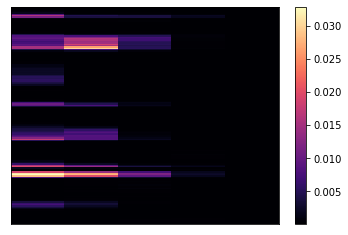

In [37]:
mel_test_dataset = MelSpectrogramDataset(phrase_df.head(), phrase_df.target.head())
plt.figure()
librosa.display.specshow(mel_test_dataset[3]['features'].data.numpy()[0])
plt.colorbar()

In [39]:
model_hidden_size = 1#256
model_embedding_size = 1#256
model_num_layers = 1

class EmbeddingModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.lstm = nn.LSTM(mel_n_channels, model_hidden_size, model_num_layers, batch_first=True)
        self.linear = nn.Linear(model_hidden_size, model_embedding_size)
        self.relu = nn.ReLU()

    def forward(self, features):
        
        #_, (hidden, _) = self.lstm(features)
        #embeds_raw = self.relu(self.linear(hidden[-1]))
        return 0#embeds_raw / torch.norm(embeds_raw, dim=1, keepdim=True)

In [41]:
EXP_PATH = '../models/checkpoints/speaker_ebbedding/basic'
NUM_WORKERS = 1
PIN_MEMORY = False
TARGET_METRIC = 'mse'

batch_size=1


loaders = {
    "train": DataLoader((MelSpectrogramDataset(phrase_df.head(), phrase_df.target.head())
                        ),
                        #worker_init_fn=worker_init_fn,
                        batch_size=batch_size, shuffle=True, drop_last=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
}

print('creat')

model =  EmbeddingModel()
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=1, factor=0.3, min_lr=1e-5)

print('2')
callbacks = [
    dl.OptimizerCallback('loss'),
    dl.SchedulerCallback(loader_key='train', metric_key='loss', mode='epoch'),
    dl.CheckpointCallback(loader_key='train', metric_key='loss', minimize=True,
                          save_n_best=1, mode='model', use_runner_logdir=True, use_logdir_postfix=True, ),
    # dl.EarlyStoppingCallback(patience=4, loader_key="valid", metric_key=TARGET_METRIC, minimize=False),
    dl.TimerCallback()
]
runner = dl.SupervisedRunner(input_key="features", target_key="targets", output_key="logits", loss_key="loss", )
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    loaders=loaders,
    num_epochs=2,#99999,#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    callbacks=callbacks,
    #engine=dl.DeviceEngine("cpu"),
    logdir=EXP_PATH,
    valid_loader="train",
    valid_metric=TARGET_METRIC,
    minimize_valid_metric=True,
    verbose=True,
    load_best_on_end=True,
    amp=True,
)

creat
2


1/2 * Epoch (train):   0%|          | 0/5 [00:00<?, ?it/s]

Keyboard Interrupt


KeyboardInterrupt: 